In [1]:
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from gym_minigrid_navigation.utils import show_video
from navigation_policy import gen_env, get_agent, run_episode, run_episodes

from rewards import get_reward_function
from utils import init_logger, switch_reproducibility_on, display_stats

init_logger('master_worker')
init_logger('navigation_policy')

In [3]:
from pyhocon import ConfigFactory

config = ConfigFactory.parse_file('../conf/minigrid_master_worker.hocon')
config['env']['video_path'] = './video/'

In [4]:
switch_reproducibility_on(config['seed'])

# Train worker

In [5]:
reward_functions = get_reward_function(config)
env = gen_env(config['env'], reward_functions)

In [6]:
worker_agent = get_agent(config)

In [7]:
scores, steps = run_episodes(env, worker_agent, None, n_episodes=1000, verbose=config['training.verbose'])

2021-03-11 12:15:04,404 INFO    navigation_policy      : Episode: 100. Average score: -22.24. Average steps: 83.49
2021-03-11 12:15:16,447 INFO    navigation_policy      : Episode: 200. Average score: -2.75. Average steps: 21.20
2021-03-11 12:15:23,276 INFO    navigation_policy      : Episode: 300. Average score: -0.11. Average steps: 12.58
2021-03-11 12:15:28,665 INFO    navigation_policy      : Episode: 400. Average score: 0.64. Average steps: 10.32
2021-03-11 12:15:35,679 INFO    navigation_policy      : Episode: 500. Average score: 0.99. Average steps: 10.19
2021-03-11 12:15:40,539 INFO    navigation_policy      : Episode: 600. Average score: 1.17. Average steps: 7.96
2021-03-11 12:15:44,779 INFO    navigation_policy      : Episode: 700. Average score: 1.17. Average steps: 7.49
2021-03-11 12:15:49,445 INFO    navigation_policy      : Episode: 800. Average score: 1.38. Average steps: 7.67
2021-03-11 12:15:53,660 INFO    navigation_policy      : Episode: 900. Average score: 1.61. Ave

# Train master

In [8]:
worker_agent.qnetwork_local.master

Flattener(
  (model): MLP(
    (model): Sequential(
      (0): Linear(in_features=108, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Tanh()
    )
  )
)

In [9]:
state_size = worker_agent.qnetwork_local.master.model.model[0].in_features
emb_size = worker_agent.qnetwork_local.master.model.model[2].out_features
print(state_size, emb_size)

108 64


In [10]:
from gym_minigrid_navigation.encoders import get_encoders
state_encoder, _ = get_encoders(config)

In [11]:
from ddpg import DDPGAgentMaster, MasterNetwork

master_network = MasterNetwork(emb_size, state_encoder)
master_agent = DDPGAgentMaster(master_network, config)

In [12]:
import gym
from gym.wrappers import Monitor
from gym_minigrid_navigation.environments import FullyObsWrapper, FullyRenderWrapper, ImgObsWrapper

env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(FullyObsWrapper(env))
env = FullyRenderWrapper(env)  
env = Monitor(env, config.env.video_path, force=True)

In [13]:
scores, steps = run_episodes(env, worker_agent, master_agent, n_episodes=1000, verbose=config['training.verbose'])

2021-03-11 12:16:47,629 INFO    navigation_policy      : Episode: 100. Average score: 0.70. Average steps: 84.35
2021-03-11 12:17:23,453 INFO    navigation_policy      : Episode: 200. Average score: 0.79. Average steps: 58.76
2021-03-11 12:18:06,261 INFO    navigation_policy      : Episode: 300. Average score: 0.74. Average steps: 73.15
2021-03-11 12:18:45,522 INFO    navigation_policy      : Episode: 400. Average score: 0.73. Average steps: 76.55
2021-03-11 12:19:21,898 INFO    navigation_policy      : Episode: 500. Average score: 0.75. Average steps: 70.58
2021-03-11 12:19:56,735 INFO    navigation_policy      : Episode: 600. Average score: 0.76. Average steps: 67.28
2021-03-11 12:20:29,226 INFO    navigation_policy      : Episode: 700. Average score: 0.78. Average steps: 62.60
2021-03-11 12:21:13,787 INFO    navigation_policy      : Episode: 800. Average score: 0.69. Average steps: 85.55
2021-03-11 12:22:12,189 INFO    navigation_policy      : Episode: 900. Average score: 0.60. Aver

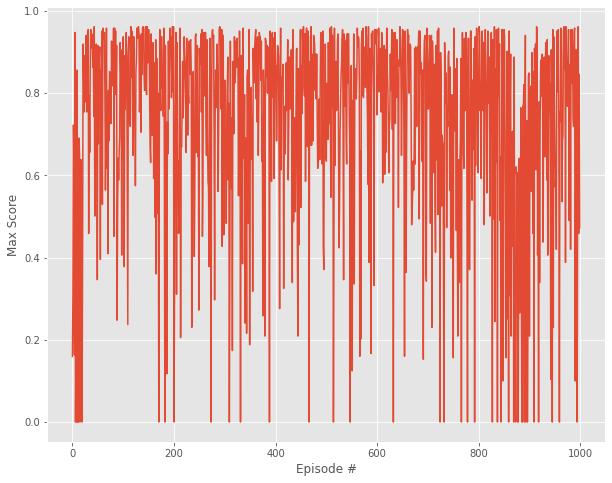

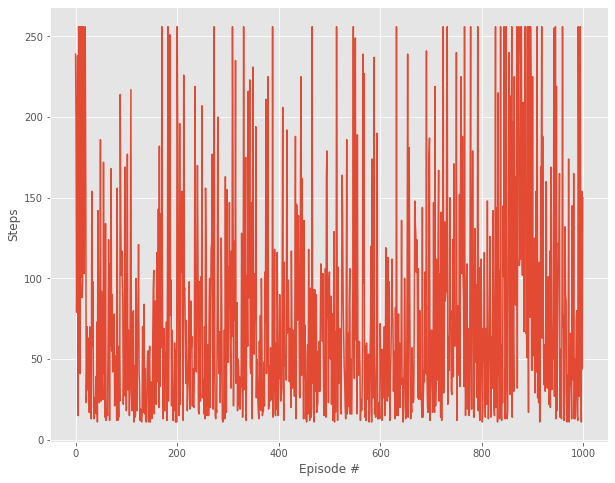

In [14]:
display_stats(scores, steps)